# Data Exploration

In [1]:
# import libraries

import pandas as pd
import numpy as np
import math as m
from ast import literal_eval
import itertools
import re


from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (VotingClassifier, 
                              RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              BaggingClassifier
                             )
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import ClusterCentroids
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             recall_score, 
                             precision_score,
                             precision_recall_curve,
                             make_scorer,
                             confusion_matrix,
                             plot_confusion_matrix,
                             plot_roc_curve,
                             classification_report,
                             roc_curve,
                             auc,
                             plot_precision_recall_curve,
                             roc_auc_score,
                             log_loss
                             
)
# For plotting the tree.
from sklearn.tree import export_graphviz, plot_tree
# from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

import joblib
import xgboost as xgb
from xgboost import plot_importance

## Import and Preprocess Data

In [2]:
df = pd.read_csv('data/steam_clean.csv')

In [3]:
# Preprocessing functions

def clean_initalprice(df):
    """ Change initial price to int and return as dollar amount """
    df = df.copy()
    
    df['initialprice'] = df['initialprice'].astype(int)
    df['initialprice'] = df.loc[df['initialprice'] > 0, 'initialprice'] / 100
    df['initialprice'] = df['initialprice'].fillna(0)
    
    return df

# def process_priceoverview(df):
#     df = df.copy()
        
#     def parse_price(x):
#         if x is not np.nan:
#             return literal_eval(x)
#         else:
#             return {'currency': 'USD', 'initial': -1, 'final': -1, 'discount_percent': -1}
    
#     # evaluate as dictionary and set to -1 if missing
#     df['price_overview'] = df['price_overview'].apply(parse_price)
    
#     # Create columns from currency and initial values
#     df['currency'] = df['price_overview'].apply(lambda x: x['currency'])
#     df['initial_price'] = df['price_overview'].apply(lambda x: x['initial'])
#     df['final_price'] = df['price_overview'].apply(lambda x: x['final'])
#     df['discount_percent'] = df['price_overview'].apply(lambda x: x['discount_percent'])
    
    
#     # Set price of free games to 0
#     df.loc[df['is_free'], 'intial_price'] = 0
    
#     return df

# price_data = process_priceoverview(price_overview)[['appid','name', 'currency', 'initial_price', 
#                                             'final_price', 'discount_percent','price', 'discount', 'is_free']]
# price_data.head()

def rename_columns(df):
    
    df = df.copy()
    
    df.rename(columns = {'average_forever': 'average_playtime', 'median_forever': 'median_playtime', 
                         'positive': 'positive_ratings', 'negative': 'negative_ratings', 'owners_max': 'total_owners'}, inplace = True)
    return df

# https://www.esrb.org/ratings-guide/    
def required_age(df):
    """Format age according the the US ESRB Rating Category"""
    # ESRB Age Rating: 10, 13, 17, 18
    cut_points = [-1, 0, 10, 13, 17, 30]
    label_values = [0, 10, 13, 17, 18]
    
    df['required_age'] = pd.cut(df['required_age'], bins=cut_points, labels=label_values)
    
    return df

def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))




In [4]:
# def process_requirements(df):

#     df = df.copy()

#     # remove rows with missing pc requirements
#     df = df[df['pc_requirements'] != '[]']

#     df['requirements_clean'] = (df['pc_requirements']
#                                               .str.replace(r'\\[rtn]', '')
#                                               .str.replace(r'<[pbr]{1,2}>', ' ')
#                                               .str.replace(r'<[\/"=\w\s]+>', '')
#                                          )

#     df['requirements_clean'] = df['requirements_clean'].apply(lambda x: literal_eval(x))

#     # split out minimum and recommended into separate columns
#     df['minimum_req'] = df['requirements_clean'].apply(lambda x: x['minimum'].replace('Minimum:', '').strip() if 'minimum' in x.keys() else np.nan)
#     df['recommended_req'] = df['requirements_clean'].apply(lambda x: x['recommended'].replace('Recommended:', '').strip() if 'recommended' in x.keys() else np.nan)

#     df.drop('requirements_clean', axis=1, inplace = True)
    
#     df.drop(['pc_requirements', 'mac_requirements', 'linux_requirements'], axis=1, inplace = True)
    
#     return df

In [5]:
def drop_cols(df):
    """ Drop unnecessary columns """
    df = df.copy()
    
    df.drop(columns = cols, axis = 0, inplace = True)
    
    return df

In [6]:
def clean_df(df):
    
    df = df.copy()
    
    df = clean_initalprice(df)
    df = rename_columns(df)
    df = required_age(df)
    
    df['release_date'] = pd.to_datetime(df['release_date'], yearfirst = True, errors = 'coerce')
    
    df['release_year'] = df['release_date'].dt.year
    
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    
    df['owners>=500000'] = df['total_owners'].map(lambda x: 1 if x >= 500000 else 0)
    
    return df

df1 = clean_df(df)
df1

,type,name,appid,required_age,is_free,detailed_description,about_the_game,short_description,pc_requirements,mac_requirements,...,genre,ccu,tags,review_score,rating,owners_min,total_owners,release_year,total_ratings,owners>=500000
0,game,Counter-Strike,10,0,False,Disfruta del juego de acción en línea n° 1 en ...,Disfruta del juego de acción en línea n° 1 en ...,Disfruta del juego de acción en línea n° 1 en ...,{'minimum': '<p><strong>Mínimo:</strong> proce...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,...,Action,14724,"{'Action': 5383, 'FPS': 4807, 'Multiplayer': 3...",0.97,96.0,10000000,20000000,2000,199503,1
1,game,Team Fortress Classic,20,0,False,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,...,Action,95,"{'Action': 746, 'FPS': 307, 'Multiplayer': 258...",0.86,83.0,5000000,10000000,1999,6390,1
2,game,Day of Defeat,30,0,False,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,...,Action,134,"{'FPS': 789, 'World War II': 250, 'Multiplayer...",0.90,87.0,5000000,10000000,2003,5609,1
3,game,Deathmatch Classic,40,0,False,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,...,Action,7,"{'Action': 630, 'FPS': 140, 'Classic': 108, 'M...",0.82,79.0,5000000,10000000,2001,2293,1
4,game,Half-Life: Opposing Force,50,0,False,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,...,Action,116,"{'FPS': 883, 'Action': 324, 'Classic': 252, 'S...",0.95,92.0,5000000,10000000,1999,14232,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,game,Do Something,1810240,0,True,You buy a game that you can pass to the end. F...,You buy a game that you can pass to the end. F...,"After a few hours of epidemic, you go straight...",{'minimum': '<strong>Minimum:</strong><br><ul ...,{'minimum': '<strong>Minimum:</strong><br><ul ...,...,"Action, Adventure",1,"{'Zombies': 253, 'Action': 252, 'Survival Horr...",0.30,40.0,100000,200000,2021,10,0
5464,game,Deadly Racing Duel,1842410,0,False,Test your driving skills in this unusual racin...,Test your driving skills in this unusual racin...,Deadly Racing Duel - in the role of a racer wh...,{'minimum': '<strong>Minimum:</strong><br><ul ...,[],...,Indie,0,"{'Difficult': 248, 'Rogue-like': 243, 'Pixel G...",0.90,71.0,100000,200000,2022,10,0
5465,game,Dungeon Crawler,1873960,0,False,"<img src=""https://cdn.akamai.steamstatic.com/s...","<img src=""https://cdn.akamai.steamstatic.com/s...","Dungeon Crawler is a round-based, third-person...",{'minimum': '<strong>Minimum:</strong><br><ul ...,{'minimum': '<strong>Minimum:</strong><br><ul ...,...,"Casual, Indie, RPG, Strategy",0,"{'Turn-Based Combat': 443, 'Strategy': 439, 'D...",0.62,56.0,100000,200000,2022,8,0
5466,game,AI Roguelite,1889620,0,False,<strong>ATTENTION: This game requires an NVIDI...,<strong>ATTENTION: This game requires an NVIDI...,"Infinite text-based RPG, powered by cutting-ed...",{'minimum': '<strong>Minimum:</strong><br><ul ...,[],...,"Adventure, Indie, RPG, Early Access",0,"{'Early Access': 448, 'RPG': 407, 'Text-Based'...",0.67,58.0,100000,200000,2022,6,0


In [7]:
df1.describe()

,appid,positive_ratings,negative_ratings,average_playtime,average_2weeks,median_playtime,median_2weeks,price,initialprice,discount,ccu,review_score,rating,owners_min,total_owners,release_year,total_ratings,owners>=500000
count,5.468000e+03,5.468000e+03,5468.000000,5468.000000,5468.000000,5468.000000,5468.000000,5468.000000,5468.000000,5468.000000,5468.000000,5468.000000,5468.000000,5.468000e+03,5.468000e+03,5468.000000,5.468000e+03,5468.000000
mean,5.577255e+05,1.085339e+04,1706.856986,801.014265,67.057059,644.728786,71.972933,10.819034,11.322368,3.277432,1136.625274,0.784413,75.464704,5.750183e+05,1.256053e+06,2016.127469,1.256024e+04,0.627286
std,3.997876e+05,8.870597e+04,16960.706028,3330.751755,422.053662,4334.704863,463.728234,12.243063,12.483993,14.900611,18515.828066,0.160943,14.474719,2.380058e+06,5.029837e+06,3.454323,1.024963e+05,0.483571
min,1.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05,2.000000e+05,1997.000000,0.000000e+00,0.000000
25%,2.737025e+05,5.200000e+02,133.000000,93.000000,0.000000,68.000000,0.000000,0.780000,0.990000,0.000000,1.000000,0.700000,67.000000,1.000000e+05,2.000000e+05,2014.000000,7.237500e+02,0.000000
50%,4.381200e+05,1.653000e+03,318.000000,243.000000,0.000000,224.500000,0.000000,7.990000,9.990000,0.000000,11.000000,0.830000,79.000000,2.000000e+05,5.000000e+05,2016.000000,2.096500e+03,1.000000
75%,7.745485e+05,4.974250e+03,856.500000,590.000000,0.000000,441.000000,0.000000,15.990000,19.990000,0.000000,87.000000,0.910000,87.000000,5.000000e+05,1.000000e+06,2019.000000,5.964250e+03,1.000000
max,1.903490e+06,5.559446e+06,876946.000000,120223.000000,11761.000000,225183.000000,11761.000000,99.990000,99.990000,90.000000,862238.000000,1.000000,98.000000,1.000000e+08,2.000000e+08,2022.000000,6.302487e+06,1.000000


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5468 entries, 0 to 5467
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   type                  5468 non-null   object        
 1   name                  5468 non-null   object        
 2   appid                 5468 non-null   int64         
 3   required_age          5468 non-null   category      
 4   is_free               5468 non-null   bool          
 5   detailed_description  5468 non-null   object        
 6   about_the_game        5468 non-null   object        
 7   short_description     5468 non-null   object        
 8   pc_requirements       5468 non-null   object        
 9   mac_requirements      5468 non-null   object        
 10  linux_requirements    5468 non-null   object        
 11  price_overview        4124 non-null   object        
 12  platforms             5468 non-null   object        
 13  metacritic        

In [9]:
# CAT = ['type', 'name', 'appid', 'is_free', 'detailed_description', 'about_the_game', 
#       'short_description','platforms', 'categories','developer', 
#       'publisher','languages','genre','tags']


CAT = df1.select_dtypes(include= ['object', 'category', 'bool'])
NUM = df1.select_dtypes(include= [np.number, 'datetime64'])

In [10]:
NUM

,appid,release_date,positive_ratings,negative_ratings,average_playtime,average_2weeks,median_playtime,median_2weeks,price,initialprice,discount,ccu,review_score,rating,owners_min,total_owners,release_year,total_ratings,owners>=500000
0,10,2000-11-01,194508,4995,12298,3385,202,6680,9.99,9.99,0,14724,0.97,96.0,10000000,20000000,2000,199503,1
1,20,1999-04-01,5485,905,624,0,23,0,4.99,4.99,0,95,0.86,83.0,5000000,10000000,1999,6390,1
2,30,2003-05-01,5052,557,735,909,10,909,4.99,4.99,0,134,0.90,87.0,5000000,10000000,2003,5609,1
3,40,2001-06-01,1876,417,1362,0,19,0,4.99,4.99,0,7,0.82,79.0,5000000,10000000,2001,2293,1
4,50,1999-11-01,13557,675,651,37,130,37,4.99,4.99,0,116,0.95,92.0,5000000,10000000,1999,14232,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,1810240,2021-12-15,3,7,0,0,0,0,0.00,0.00,0,1,0.30,40.0,100000,200000,2021,10,0
5464,1842410,2022-01-31,9,1,0,0,0,0,10.99,10.99,0,0,0.90,71.0,100000,200000,2022,10,0
5465,1873960,2022-02-25,5,3,0,0,0,0,5.99,5.99,0,0,0.62,56.0,100000,200000,2022,8,0
5466,1889620,2022-03-02,4,2,0,0,0,0,4.99,4.99,0,0,0.67,58.0,100000,200000,2022,6,0


## Data Overview & Understanding

In [11]:
NUM.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,appid,positive_ratings,negative_ratings,average_playtime,average_2weeks,median_playtime,median_2weeks,price,initialprice,discount,ccu,review_score,rating,owners_min,total_owners,release_year,total_ratings,owners>=500000
count,5468.00000,5468.00000,5468.00000,5468.00000,5468.00000,5468.00000,5468.00000,5468.00000,5468.00000,5468.00000,5468.00000,5468.00000,5468.00000,5468.00000,5468.00000,5468.00000,5468.00000,5468.00000
mean,557725.53109,10853.38753,1706.85699,801.01426,67.05706,644.72879,71.97293,10.81903,11.32237,3.27743,1136.62527,0.78441,75.46470,575018.28822,1256053.40161,2016.12747,12560.24451,0.62729
std,399787.63250,88705.96827,16960.70603,3330.75176,422.05366,4334.70486,463.72823,12.24306,12.48399,14.90061,18515.82807,0.16094,14.47472,2380058.12875,5029837.25210,3.45432,102496.34926,0.48357
min,10.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100000.00000,200000.00000,1997.00000,0.00000,0.00000
25%,273702.50000,520.00000,133.00000,93.00000,0.00000,68.00000,0.00000,0.78000,0.99000,0.00000,1.00000,0.70000,67.00000,100000.00000,200000.00000,2014.00000,723.75000,0.00000
50%,438120.00000,1653.00000,318.00000,243.00000,0.00000,224.50000,0.00000,7.99000,9.99000,0.00000,11.00000,0.83000,79.00000,200000.00000,500000.00000,2016.00000,2096.50000,1.00000
75%,774548.50000,4974.25000,856.50000,590.00000,0.00000,441.00000,0.00000,15.99000,19.99000,0.00000,87.00000,0.91000,87.00000,500000.00000,1000000.00000,2019.00000,5964.25000,1.00000
max,1903490.00000,5559446.00000,876946.00000,120223.00000,11761.00000,225183.00000,11761.00000,99.99000,99.99000,90.00000,862238.00000,1.00000,98.00000,100000000.00000,200000000.00000,2022.00000,6302487.00000,1.00000


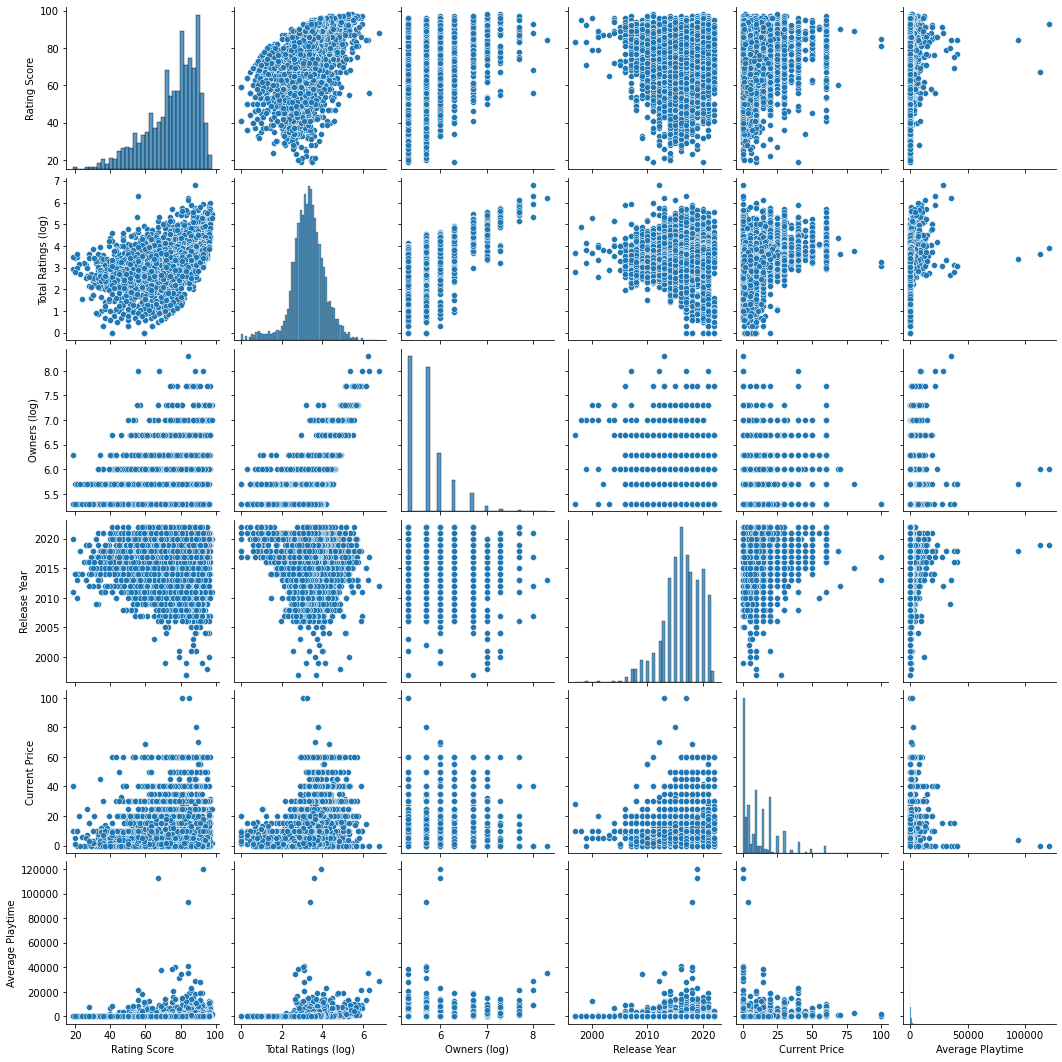

In [12]:
df = df1[(df1['total_owners'] > 0) & (df1['total_ratings'] > 0)].copy()
eda = pd.DataFrame(zip(df['rating'], 
                            np.log10(df['total_ratings']), 
                            np.log10(df['total_owners']), 
                            df['release_year'], 
                            df.price,
                            df['average_playtime']),
                       columns = ['Rating Score', 'Total Ratings (log)', 'Owners (log)', 
                                  'Release Year', 'Current Price', 'Average Playtime'])
sns.pairplot(eda)
plt.show()

### Number of Games Released

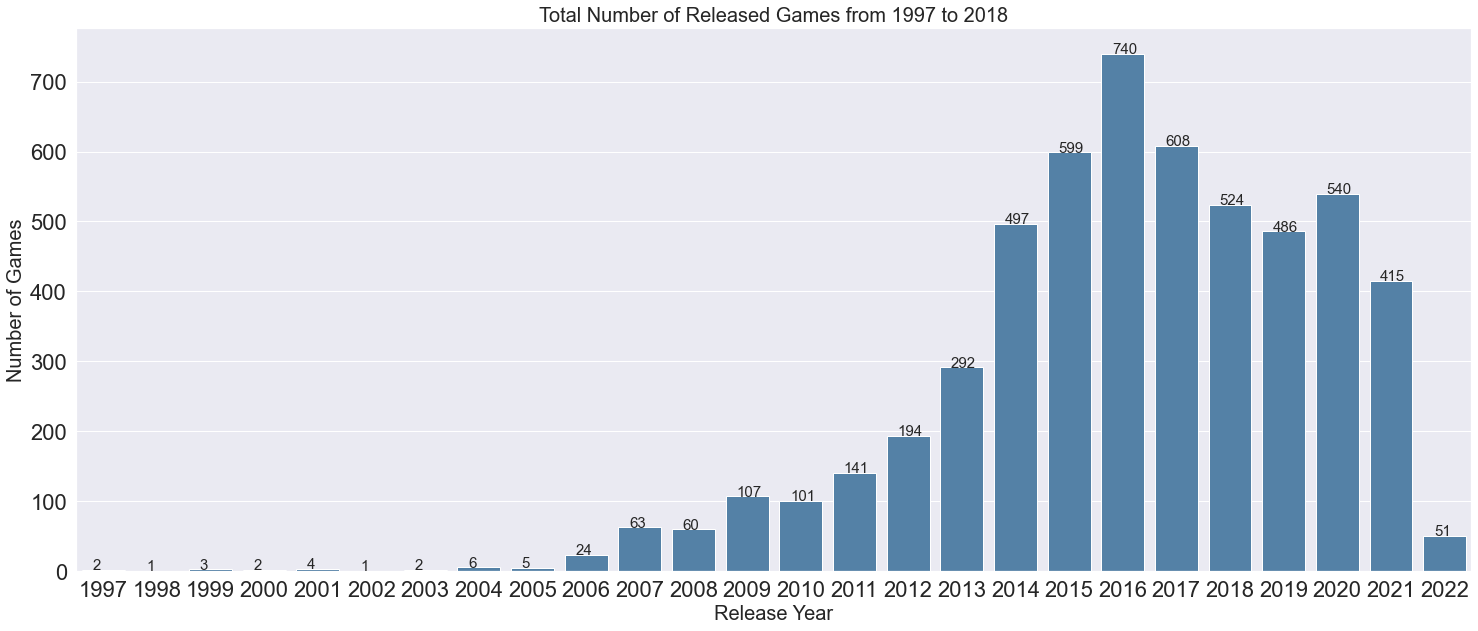

In [13]:
# add breakdown by number of owners
plt.figure(figsize=(25,10))
sns.set_theme(style = 'darkgrid', font_scale = 2)
ax = sns.countplot(x=df1['release_year'],data=df1, color= 'steelblue')
plt.title('Total Number of Released Games from 1997 to 2018', fontsize = 20)
plt.ylabel('Number of Games', fontsize = 20)
plt.xlabel('Release Year', fontsize = 20)

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), size=15)
    
plt.show()

<AxesSubplot:xlabel='total_owners', ylabel='count'>

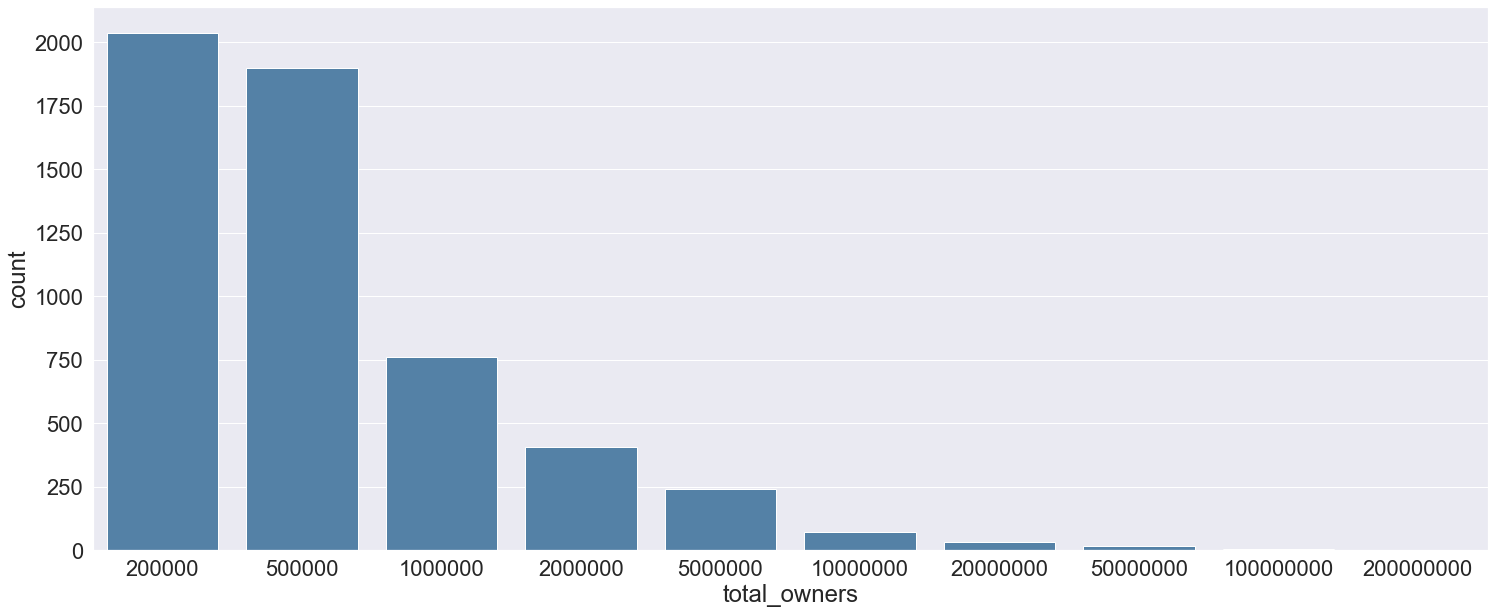

In [14]:
# Plotting the count of owners
# Make 500,000 our threshold
plt.figure(figsize=(25,10))
sns.countplot(x=df1['total_owners'],data=df1, color= 'steelblue')

### Top Genres, Ratings, Owners, Games. and Languages

In [15]:
def fill_col(df):
    df = df.str.replace(' ', '')
    col_dict = df.apply(lambda x: x.split(',')).apply(lambda y:{values: 1 for values in y}).values
    col_fill = pd.DataFrame(list(col_dict)).fillna(0)
    return col_fill

,Number of Genres
Genres,
Indie,3323
Action,2645
Adventure,2072
Strategy,1382
RPG,1314
Casual,1312
Simulation,1143
FreetoPlay,998
MassivelyMultiplayer,417


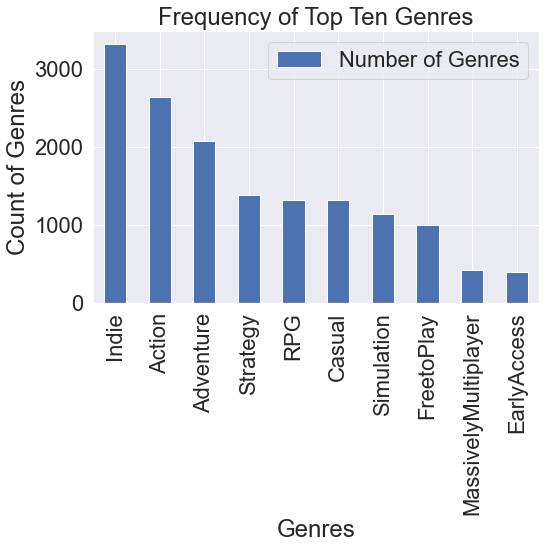

In [16]:
genres = fill_col(df1['genre'])
genres[['name', 'release_year', 'average_playtime', 'total_owners', 'rating', 'price']] = df1[['name', 'release_year', 'average_playtime', 'total_owners', 'rating', 'price']]
first_column = genres.pop('name')
second_column = genres.pop('release_year')
genres.insert(0, 'name', first_column)
genres.insert(1,'release_year', second_column)

x = genres.iloc[:,2:-4]
x.columns

genre_name = x.columns
genre_total = []
for value in genre_name:
    genre_total.append(genres[genres[value] == 1]['price'].count())
    
top_genres_data = {'Number of Genres': genre_total}
top_genres = pd.DataFrame(top_genres_data, index=genre_name)
top_genres.index.name = 'Genres'

# display number on chart
# data leakage?
genre_plot = top_genres.sort_values(by = 'Number of Genres', ascending = False).head(10)
display(genre_plot)
ax = genre_plot.plot.bar(figsize=(8,5))
ax.set_ylabel('Count of Genres')
ax.set_xlabel('Genres')
ax.set_title('Frequency of Top Ten Genres')
plt.show()

### Top 10 Rated Games

In [17]:
df_games = df1[['name', 'release_year', 'average_playtime', 'total_owners', 'rating', 'price']]
display(df_games.sort_values(by = 'rating', ascending = False).head(10))

,name,release_year,average_playtime,total_owners,rating,price
22,Portal 2,2011,875,20000000,98.0,1.99
758,Hades,2020,1767,10000000,98.0,24.99
641,Slay the Spire,2019,3572,5000000,97.0,24.99
778,ULTRAKILL,2020,327,2000000,97.0,19.99
303,The Binding of Isaac: Rebirth,2014,7271,10000000,97.0,7.49
371,RimWorld,2018,12002,5000000,97.0,31.49
495,Stardew Valley,2016,3404,20000000,97.0,14.99
507,Factorio,2020,6144,10000000,97.0,30.00
511,Wallpaper Engine,2018,3407,20000000,97.0,3.99
584,Half-Life: Alyx,2020,642,5000000,97.0,59.99


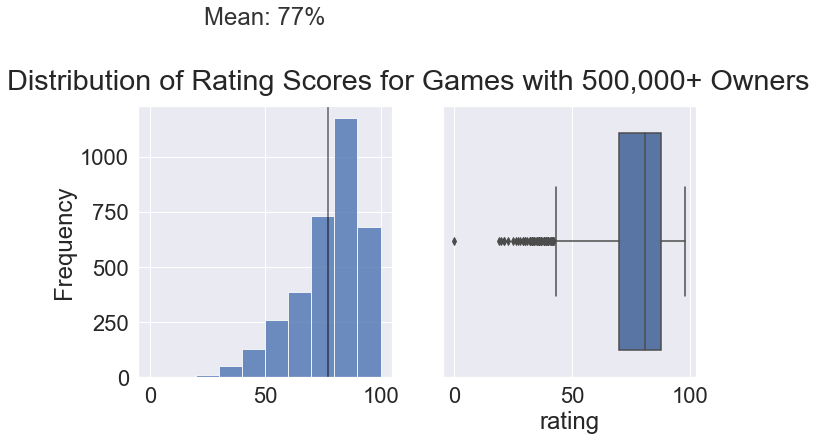

Mean rating: 77.18%


In [18]:
# over 500000 owners
df = df1[(df1.total_owners >= 500000)].copy()

fig, axarr = plt.subplots(1, 2, figsize=(10,5))

df.rating.plot.hist(range=(0, 100), bins=10, ax=axarr[0], alpha=.8)

# plotting line for mean on histogram
mean = df.rating.mean()
axarr[0].axvline(mean, c='black', alpha=.6)
axarr[0].text(mean-1, 1600, f'Mean: {mean:.0f}%', c='black', ha='right', alpha=.8)


ax = sns.boxplot(x='rating', data=df, orient='v', ax=axarr[1])
fig.suptitle('Distribution of Rating Scores for Games with 500,000+ Owners')
plt.show()

print(f'Mean rating: {df.rating.mean():.2f}%')

### Top 10 Most Owned Games

In [19]:
display(df_games.sort_values(by = 'total_owners', ascending = False).head(10))

,name,release_year,average_playtime,total_owners,rating,price
21,Dota 2,2013,35483,200000000,84.0,0.00
600,PUBG: BATTLEGROUNDS,2017,21824,100000000,56.0,0.00
24,Counter-Strike: Global Offensive,2012,28940,100000000,88.0,0.00
19,Team Fortress 2,2007,9470,100000000,93.0,0.00
744,New World,2021,9088,100000000,68.0,39.99
242,Warframe,2013,10336,50000000,89.0,0.00
745,Destiny 2,2019,7857,50000000,83.0,0.00
726,Among Us,2018,1226,50000000,91.0,4.99
818,Lost Ark,2022,2187,50000000,74.0,0.00
388,Unturned,2017,4282,50000000,90.0,0.00


### Top 10 Most Played Games

In [20]:
display(df_games.sort_values(by = 'average_playtime', ascending = False).head(10))

,name,release_year,average_playtime,total_owners,rating,price
1651,NGU IDLE,2019,120223,1000000,93.0,0.00
1619,Lords Mobile,2019,112846,1000000,67.0,0.00
3350,SAO Utils: Beta,2018,93530,500000,84.0,3.99
3142,Idling to Rule the Gods,2016,40974,500000,84.0,0.00
3332,Trailer Park Boys: Greasy Money,2018,40516,500000,77.0,0.00
4992,RutonyChat,2016,38274,200000,75.0,14.99
2466,Cadria Item Shop,2018,37855,500000,69.0,0.00
21,Dota 2,2013,35483,200000000,84.0,0.00
3606,Hearts of Iron 2 Complete,2009,34494,200000,80.0,14.99
2290,Onmyoji,2018,31604,500000,79.0,0.00


#### Which years had the highest playtime average?

<AxesSubplot:xlabel='release_year', ylabel='average_playtime'>

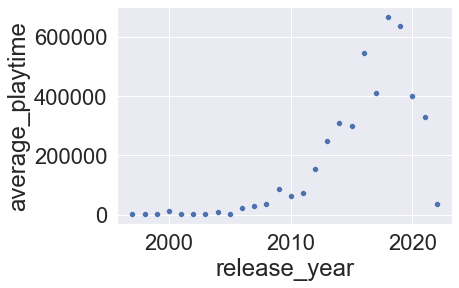

In [21]:
average_play = df_games.groupby(by = 'release_year').average_playtime.sum().sort_values(ascending = False)#.head(10)
average_play_df = pd.DataFrame(average_play)
sns.scatterplot(x='release_year', y='average_playtime', data=average_play_df)

In [22]:
df1.columns

Index(['type', 'name', 'appid', 'required_age', 'is_free',
       'detailed_description', 'about_the_game', 'short_description',
       'pc_requirements', 'mac_requirements', 'linux_requirements',
       'price_overview', 'platforms', 'metacritic', 'reviews', 'categories',
       'recommendations', 'achievements', 'release_date', 'developer',
       'publisher', 'positive_ratings', 'negative_ratings', 'average_playtime',
       'average_2weeks', 'median_playtime', 'median_2weeks', 'price',
       'initialprice', 'discount', 'languages', 'genre', 'ccu', 'tags',
       'review_score', 'rating', 'owners_min', 'total_owners', 'release_year',
       'total_ratings', 'owners>=500000'],
      dtype='object')

In [23]:
languages = fill_col(df1['languages'])
languages[['name', 'release_year', 'average_playtime', 'total_owners', 'rating', 'languages']] = df1[['name', 'release_year', 'average_playtime', 'total_owners', 'rating', 'languages']]
first_column = languages.pop('name')
second_column = languages.pop('release_year')
languages.insert(0, 'name', first_column)
languages.insert(1,'release_year', second_column)

In [24]:
languages.columns

Index(['name', 'release_year', 'English', 'French', 'German', 'Italian',
       'Spanish-Spain', 'SimplifiedChinese', 'TraditionalChinese', 'Korean',
       'Russian', 'Dutch', 'Danish', 'Finnish', 'Japanese', 'Norwegian',
       'Polish', 'Portuguese', 'Swedish', 'Thai', 'Turkish', 'Czech',
       'Hungarian', 'Portuguese-Brazil', 'Greek', 'Bulgarian', 'Romanian',
       'Ukrainian', 'Spanish-LatinAmerica', 'Vietnamese', 'Slovakian',
       'Arabic', 'Notsupported', 'average_playtime', 'total_owners', 'rating',
       'languages'],
      dtype='object')

,Number of Supported Languages
Languages,
English,5441
German,2929
French,2864
Spanish-Spain,2652
Russian,2477
Italian,2181
SimplifiedChinese,1956
Japanese,1783
Portuguese-Brazil,1486


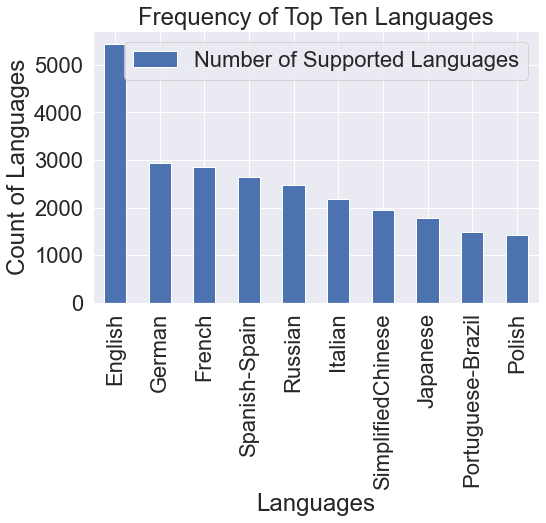

In [25]:
x = languages.iloc[:,2:-4]
x.columns

lang_type = x.columns
lang_total = []
for value in lang_type:
    lang_total.append(languages[languages[value] == 1]['name'].count())
    
lang_data = {'Number of Supported Languages': lang_total}
top_languages = pd.DataFrame(lang_data, index=lang_type)
top_languages.index.name = 'Languages'

# display number on chart
# data leakage?
lang_plot = top_languages.sort_values(by = 'Number of Supported Languages', ascending = False).head(10)
display(lang_plot)
ax = lang_plot.plot.bar(figsize=(8,5))
ax.set_ylabel('Count of Languages')
ax.set_xlabel('Languages')
ax.set_title('Frequency of Top Ten Languages')
plt.show()

## Platforms

In [26]:
def fill(df):
    df = df.str.replace(' ', '')
    col_dict = df.apply(lambda x: x.split(';')).apply(lambda y:{values: 1 for values in y}).values
    col_fill = pd.DataFrame(list(col_dict)).fillna(0)
    return col_fill

,Number of Supported Platforms
Platforms,
windows,5468
mac,2044
linux,1438


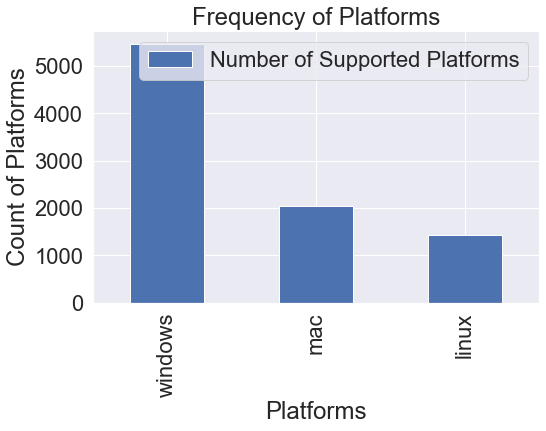

In [27]:
platforms = fill(df1['platforms'])
platforms[['name', 'release_year', 'average_playtime', 
           'total_owners', 'rating', 'platforms']] = df1[['name', 'release_year', 'average_playtime', 
                                                        'total_owners', 'rating', 'platforms']]
first_column = platforms.pop('name')
second_column = platforms.pop('release_year')
platforms.insert(0, 'name', first_column)
platforms.insert(1,'release_year', second_column)

x = platforms
x.columns[2:5]

platform_type = x.columns
platform_total = []
for value in platforms:
    platform_total.append(platforms[platforms[value] == 1]['name'].count())
    
platform_data = {'Number of Supported Platforms': platform_total}
top_platforms = pd.DataFrame(platform_data, index= platform_type)
top_platforms.index.name = 'Platforms'

# display number on chart
# data leakage?
platforms_plot = top_platforms.sort_values(by = 'Number of Supported Platforms', ascending = False).head(3)
display(platforms_plot)
ax = platforms_plot.plot.bar(figsize=(8,5))
ax.set_ylabel('Count of Platforms')
ax.set_xlabel('Platforms')
ax.set_title('Frequency of Platforms')
plt.show()

## Categorial vs. Numerical Variables

In [28]:
def make_scatterplot_feature(TARGET1, TARGET2):
    TARGET = TARGET1, TARGET2
    X_VALS = [x_col for x_col in NUM.columns if x_col != TARGET]
    
    for x in X_VALS:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,3))
        sns.scatterplot(x=x, y=TARGET1, data=NUM, ax=ax1)#.set(title=f'Price by {X_VALS}')
        sns.scatterplot(x=x, y=TARGET2, data=NUM, ax=ax2)
        # fig.tight_layout()
        plt.show()
    
    return 

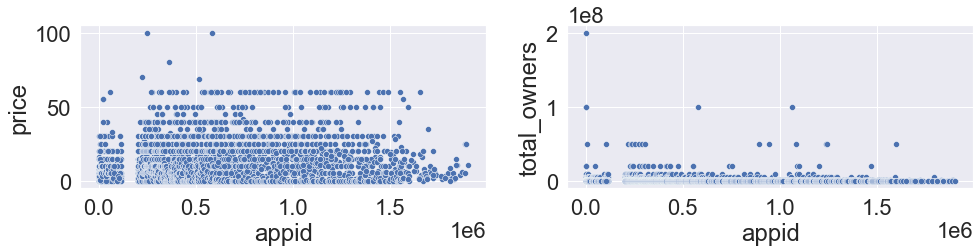

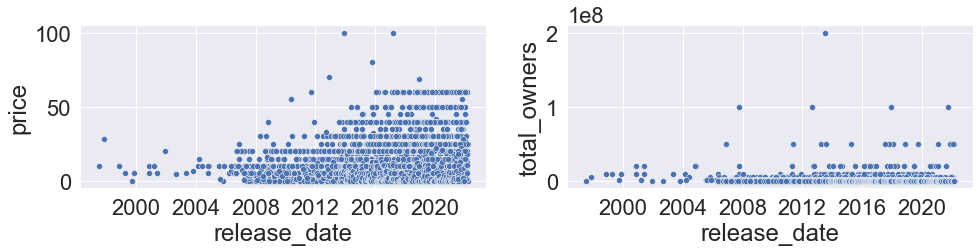

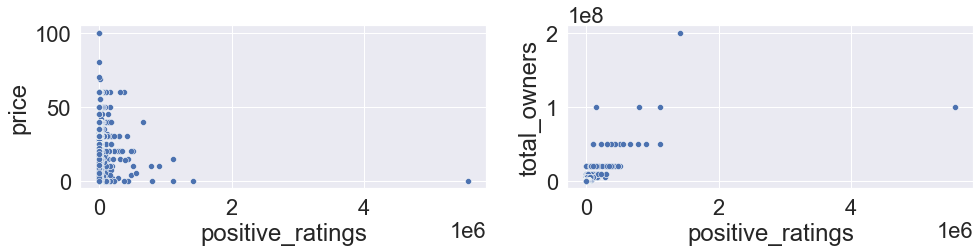

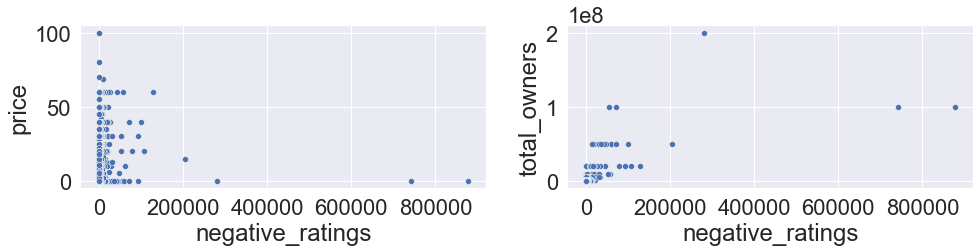

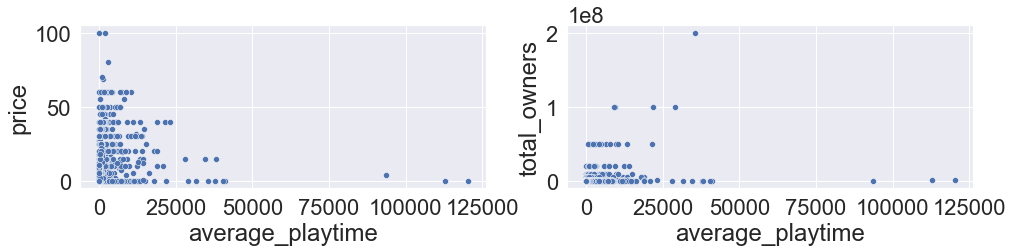

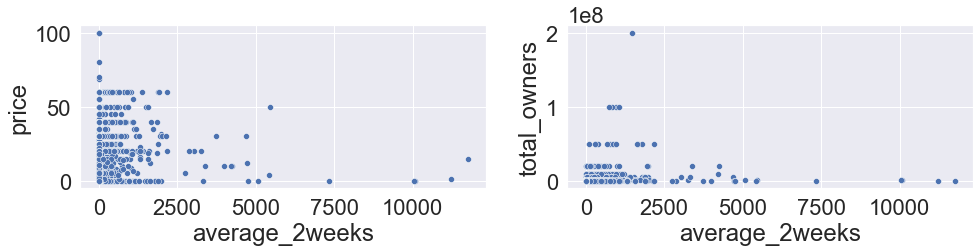

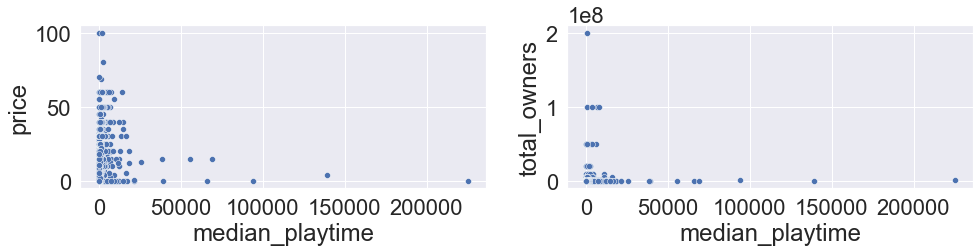

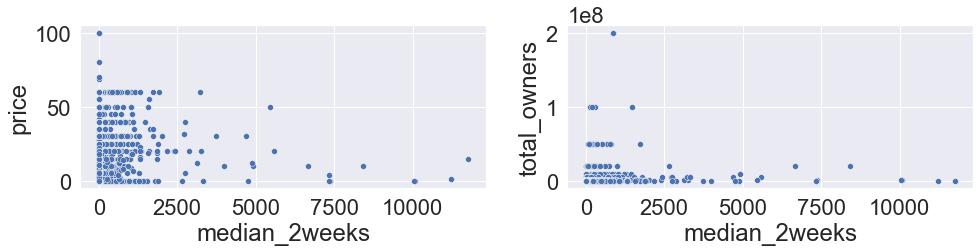

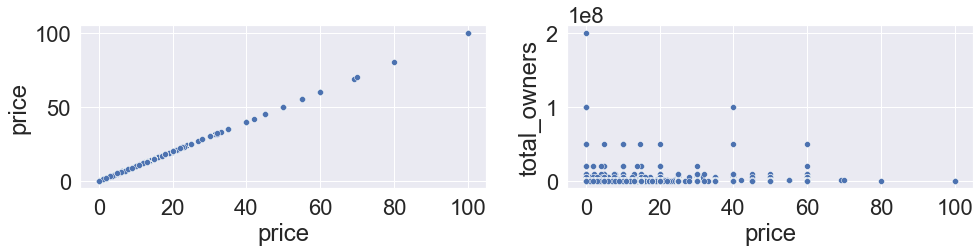

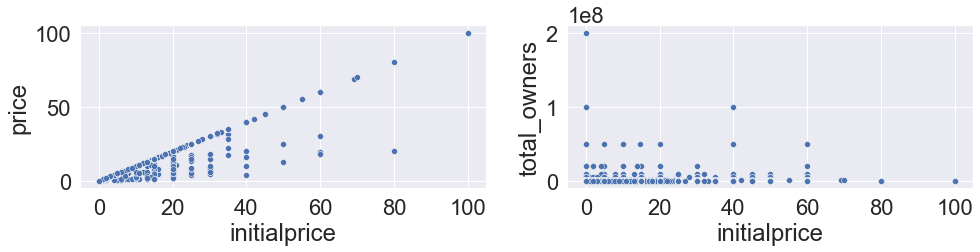

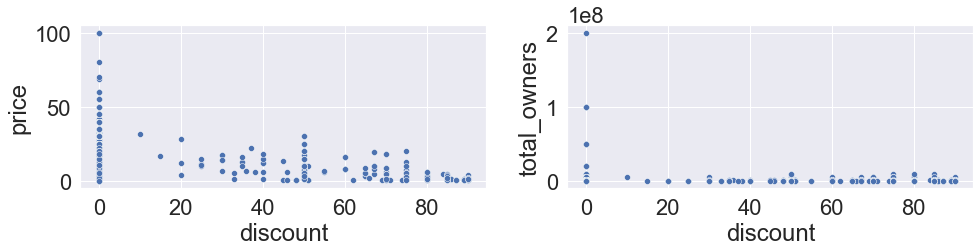

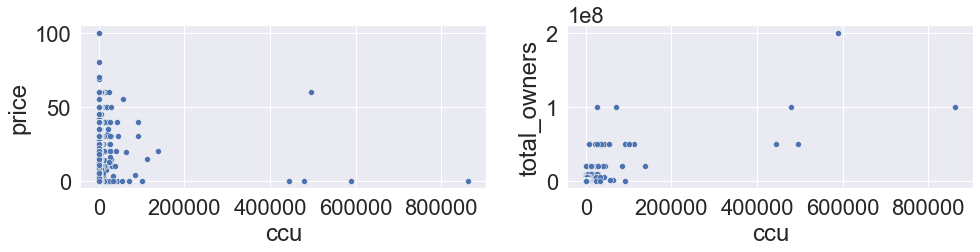

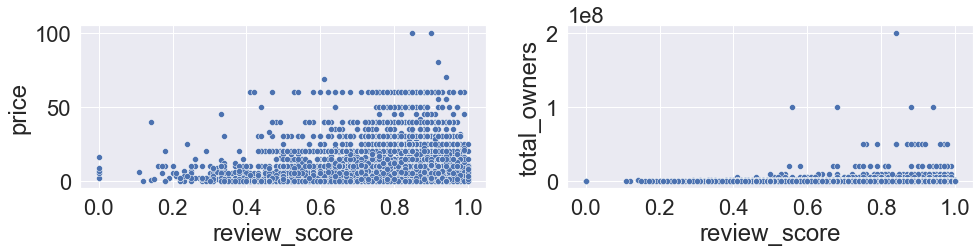

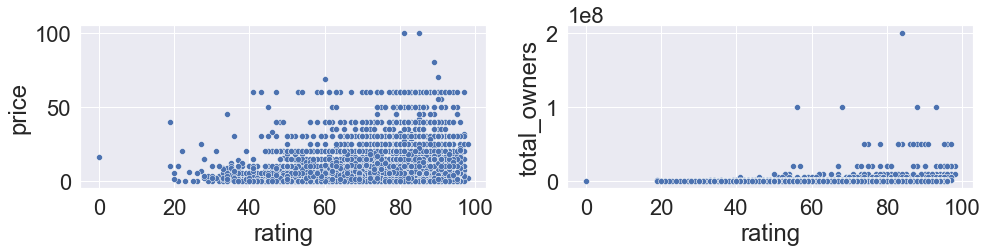

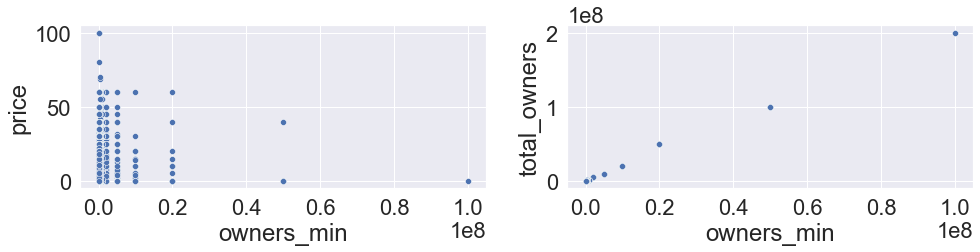

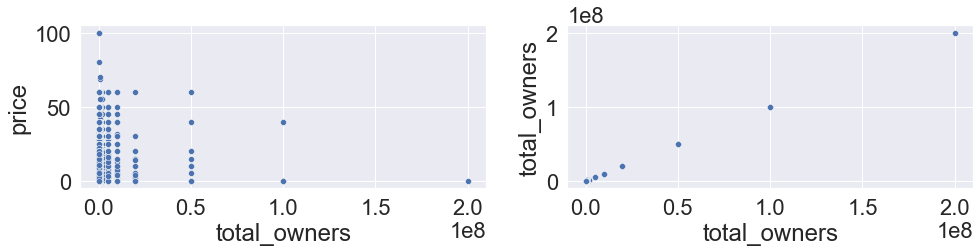

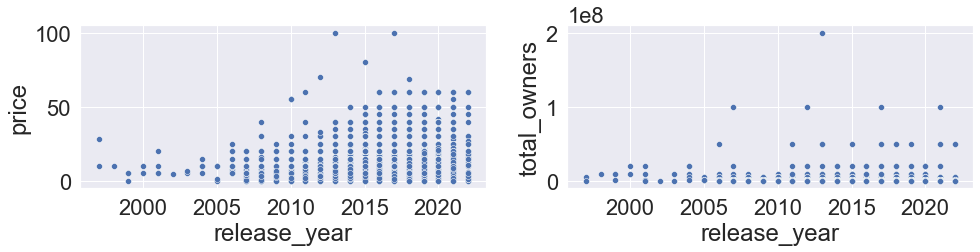

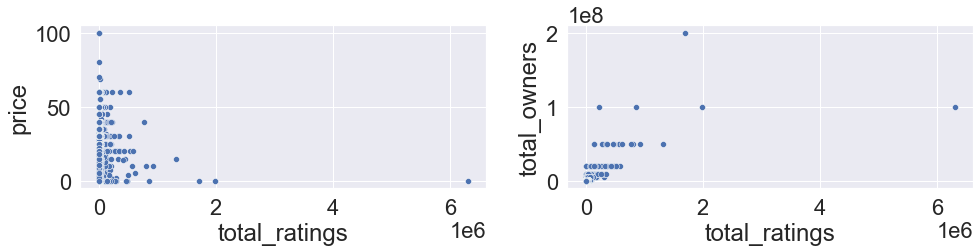

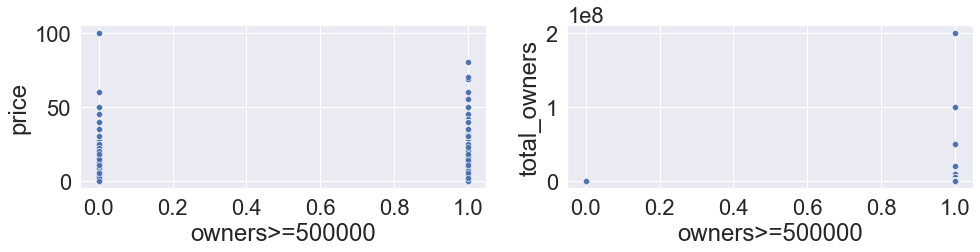

In [29]:
make_scatterplot_feature('price', 'total_owners')

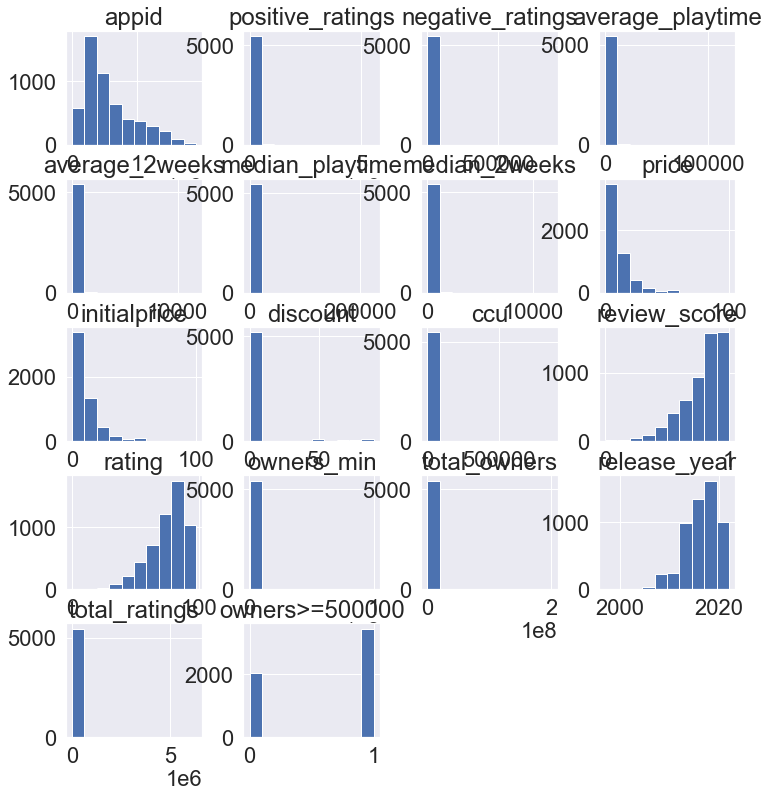

In [30]:
NUM.hist(figsize=(12,13));

## Categories

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
from google_trans_new import google_translator
from googletrans import Translator
from langdetect import detect
translator = Translator()
google_translator = google_translator()

In [34]:
# how to detect different languages and translate?
def detect_and_translate(text,target_lang):
    
    result_lang = detect(text)
    
    if result_lang == target_lang:
        return text 
    
    else:
        from google_trans_new import google_translator
        translator = google_translator()
        translate_text = translator.translate(text,lang_src=result_lang,lang_tgt=target_lang)
        return translate_text

In [35]:
df1 = df1[df1['categories'].apply(detect).eq('en')]

In [37]:
categories=df1['categories'].str.replace(";", ',').str.replace(' ','_').str.replace(',_', ',').str.replace('-','')
count_vec=CountVectorizer()
encoded=count_vec.fit_transform(categories)
count_vec.vocabulary_

1       Multiplayer,PvP,Online_PvP,Shared/Split_Screen...
2                     Multiplayer,Valve_AntiCheat_enabled
3       Multiplayer,PvP,Online_PvP,Shared/Split_Screen...
4       Singleplayer,Multiplayer,Valve_AntiCheat_enabl...
5       Multiplayer,PvP,Online_PvP,Valve_AntiCheat_ena...
                              ...                        
5463                 Singleplayer,Full_controller_support
5464                                         Singleplayer
5465                                         Singleplayer
5466                                         Singleplayer
5467                                         Singleplayer
Name: categories, Length: 5248, dtype: object

In [38]:
count_vec=CountVectorizer()
encoded=count_vec.fit_transform(categories)
count_vec.vocabulary_
encoded_categories= pd.DataFrame(encoded.toarray(), columns=count_vec.vocabulary_)
term_count=zip(encoded.toarray().sum(axis=0), count_vec.get_feature_names())
sorted_term_count=sorted(list(term_count), reverse=True)
sorted_term_count

{'multiplayer': 20,
 'pvp': 25,
 'online_pvp': 22,
 'shared': 33,
 'split_screen_pvp': 37,
 'valve_anticheat_enabled': 49,
 'remote_play_together': 31,
 'singleplayer': 34,
 'steam_cloud': 40,
 'remote_play_on_phone': 26,
 'remote_play_on_tablet': 27,
 'steam_achievements': 39,
 'steam_trading_cards': 42,
 'captions_available': 1,
 'partial_controller_support': 24,
 'includes_source_sdk': 10,
 'crossplatform_multiplayer': 6,
 'stats': 38,
 'commentary_available': 2,
 'includes_level_editor': 9,
 'steam_workshop': 44,
 'inapp_purchases': 8,
 'coop': 4,
 'full_controller_support': 7,
 'steam_leaderboards': 41,
 'remote_play_on_tv': 28,
 'steamvr_collectibles': 47,
 'online_coop': 21,
 'split_screen_coop': 36,
 'split_screen': 35,
 'lan_pvp': 14,
 'lan_coop': 13,
 'mmo': 17,
 'mods': 18,
 'vr_support': 50,
 'un_jugador': 48,
 'logros_de_steam': 16,
 'cromos_de_steam': 5,
 'compat': 3,
 '_parcial_con_control': 0,
 'incluye_editor_de_niveles': 12,
 'remote_play_para_tabletas': 30,
 'lancoop

In [47]:
import nltk
from nltk.tokenize import word_tokenize
categories = df1.categories.str.cat(sep=' ')
#function to split text into word
tokens = word_tokenize(categories)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

81


[';',
 'Steam',
 'Single-player',
 'Achievements',
 'Trading',
 'Cards',
 'PvP',
 'Cloud',
 'Co-op',
 'Remote',
 'Play',
 'Multi-player',
 'Online',
 'Full',
 'controller',
 'support',
 'on',
 'Shared/Split',
 'Screen',
 'Support',
 'Partial',
 'Controller',
 'Leaderboards',
 'TV',
 'Together',
 'In-App',
 'Purchases',
 'Workshop',
 'Tablet',
 'Stats',
 'Multiplayer',
 'Cross-Platform',
 'Includes',
 'editor',
 'level',
 'Phone',
 'available',
 'MMO',
 'Captions',
 'LAN',
 'Valve',
 'Anti-Cheat',
 'enabled',
 'VR',
 'Commentary',
 'Source',
 'SDK',
 'Turn',
 'Notifications',
 'SteamVR']

In [48]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]